Note: I have the following in `~/.ipython/profile_default/startup/setup.ipy`:

```
import numpy as np
import pandas as pd
try:
   %pylab --no-import-all inline
except:
   print('Not Jupyter notebook so skipping the %pylab setup')
```

I'm not sure how Jupyter handles exported notebooks so you may or may not need to append a cell to the beginning of the notebook with the above in order for things to run for you.

I'm going to start by just looking at the sensor data. Given the time limits it seems unlikely that I'll be able to do much with the video or thumbnails.

To start I'll build a very simple model that's a function of some kind of summary data about the sensor data so that we can collapse the time series information into a single observation (e.g. max accelaration, etc.). This may not be as powerful as a time series modeling method like an RNN or an HMM but I always like to start simple to see if the added complexity is worth it. We can also make our collapsing techniques increasingly sophisticated by, for example, looking for a particular sequence of accelarations, etc.

Let's start by looking at a few examples of the time series for data for jumping and non-jumping.

In [1]:
train_raw = pd.read_csv('./RevlMLChallengeData/TrainingDataClassification.csv')
train_raw.head()

Filename  Classification Description
0  REVL0003               1     Jumping
1  REVL0004               1     Jumping
2  REVL0005               1     Jumping
3  REVL0006               1     Jumping
4  REVL0007               1     Jumping

In [70]:
num_jump = (train_raw.Classification == 1).sum()
num_non_jump = (train_raw.Classification == 0).sum()
(num_jump, num_non_jump)

(180, 383)

So about 30% of the data is jumpers and 70% non-jumpers. Not too bad a distribution so I don't think we need to do anything to adjust for rare classes. However, it's not a ton of training data overall so I think we'll want to do cross validation with a lot of folds.

In [2]:
jumping_files = [x + '.CSV' for x in train_raw.loc[train_raw.Classification == 1, 'Filename']][0:5]
jumping_files

['REVL0003.CSV',
 'REVL0004.CSV',
 'REVL0005.CSV',
 'REVL0006.CSV',
 'REVL0007.CSV']

In [36]:
non_jumping_files = [x + '.CSV' for x in train_raw.loc[train_raw.Classification == 0, 'Filename']][0:5]
non_jumping_files

['REVL0444.CSV',
 'REVL0445.CSV',
 'REVL0446.CSV',
 'REVL0447.CSV',
 'REVL0448.CSV']

Let's look at some of the data in one of the jumping files.

In [4]:
jf1 = pd.read_csv('./RevlMLChallengeData/Data/' + jumping_files[0], header=1)
jf1.head()

Timestamp  xAccel  yAccel  zAccel  xGyro  yGyro  zGyro  xMagnet  yMagnet  \
0          0   21448    -652     292   2302  -2212  -2568     -319     -370   
1        100   17272   -1132    2252   6848   6796  -4120     -319     -370   
2        200   12476    2456    2032     42   -226  -1104     -447     -379   
3        300   13200   -1972    1824  -2506  -3780     16     -314     -402   
4        400   17580    -732    -848  -2994  -2152    246     -427     -403   

   zMagnet    ...     LatDeg  LatMin  LatSec  LonDeg  LonMin  LonSec  N/S  \
0       41    ...        NaN     NaN     NaN     NaN     NaN     NaN  NaN   
1       41    ...        NaN     NaN     NaN     NaN     NaN     NaN  NaN   
2      123    ...        NaN     NaN     NaN     NaN     NaN     NaN  NaN   
3       41    ...        NaN     NaN     NaN     NaN     NaN     NaN  NaN   
4      108    ...        NaN     NaN     NaN     NaN     NaN     NaN  NaN   

   E/W  Speed(Km/h)  Altitude  
0  NaN          NaN       NaN  
1  NaN          NaN       NaN  
2  NaN          NaN       NaN  
3  NaN          NaN       NaN  
4  NaN          NaN       NaN  

[5 rows x 22 columns]

In [5]:
jf1 = jf1.dropna(how='all', axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f941071bfd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9410422b70>]], dtype=object)

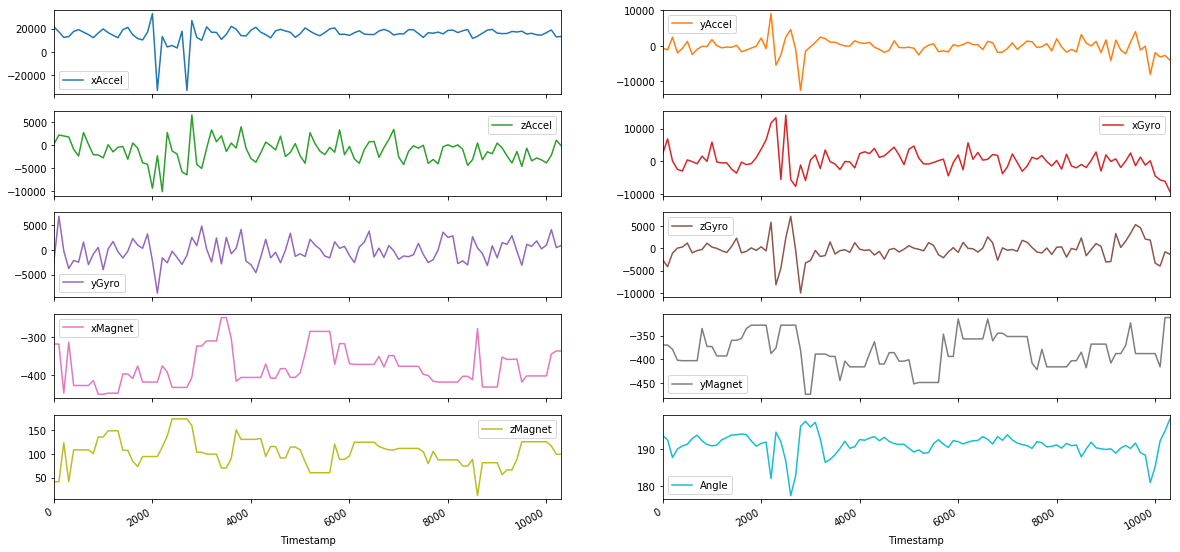

In [6]:
jf1.plot(x='Timestamp', subplots=True, layout=(-1,2), figsize=(20, 10))

Looking at the video for this one I don't really see a jump - it kind of looks like somebody stumbles at 0:02 but that's it. I'm guessing that's the big xAccel we see above at about 2 seconds in. Similarly, the gyros seem to spike at around that time as well.

For the next one to manually explore I first watched a few videos to see if I could find a more obvious jump. REVL0004 has, to my eyes, a more obvious jump at about 4 seconds in so lets see what that looks like:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9410280278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f940bfa0ba8>]], dtype=object)

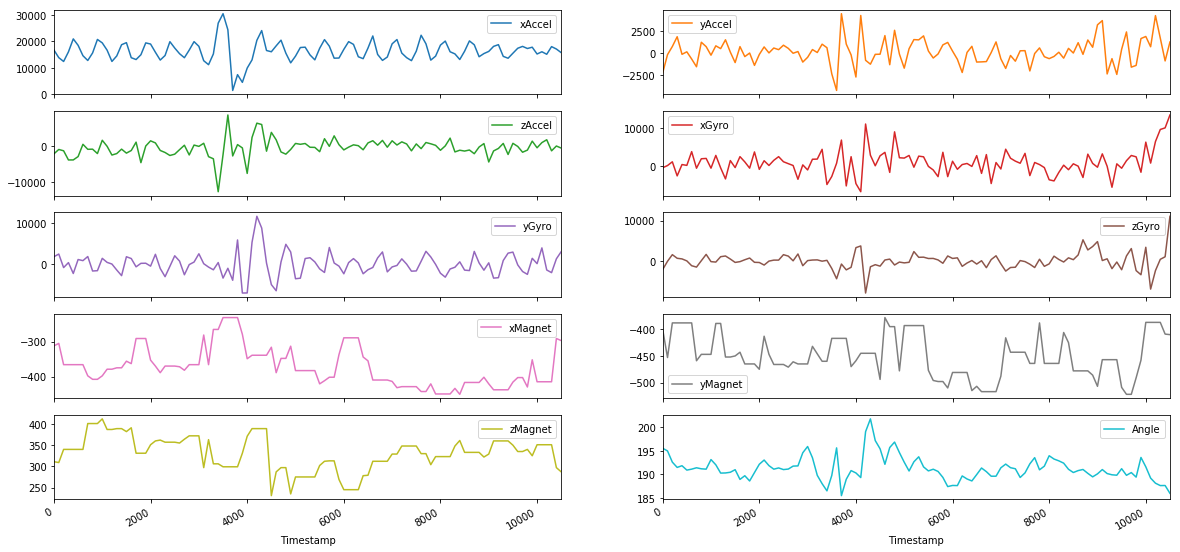

In [7]:
jf2 = pd.read_csv('./RevlMLChallengeData/Data/' + jumping_files[1], header=1)
jf2 = jf2.dropna(how='all', axis=1)
jf2.plot(x='Timestamp', subplots=True, layout=(-1,2), figsize=(20, 10))

Again we see a big spike in xAccel around the time of the In this one we also see some movement in yAccel and zAccel. I'm a bit surprised that the x direction is where the big acceleration is: I'd have expected x to be forward/backward, y to be left/right, and z to be up/down but perhaps it's reversed? Or, perhaps it's because both of these jumps seem to more like forward skips that big up/down jumps.

Let's look at some non-jumping sensor data to compare.

In [23]:
def load_sensor_file(file_with_csv):
    df = pd.read_csv('./RevlMLChallengeData/Data/' + file_with_csv, header=1)
    return df.dropna(how='all', axis=1)
    
def multiplot_file(file_basename):
    """Loads the file with the given 'base name' (name without directory), and then produces a plot like
    the ones above. Also returns the loaded DataFrame."""
    df = load_sensor_file(file_basename)
    df.plot(x='Timestamp', subplots=True, layout=(-1,2), figsize=(20, 10))
    return df
    

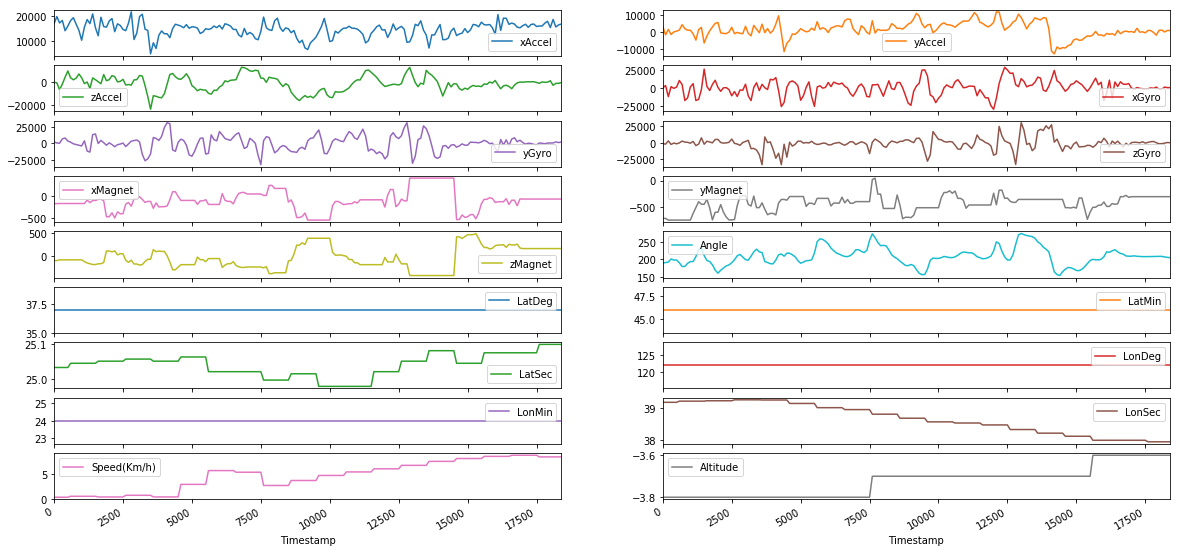

In [24]:
nj1 = multiplot_file(non_jumping_files[0])

Timestamp  xAccel  yAccel  zAccel  xGyro  yGyro  zGyro  xMagnet  yMagnet  \
0          0   -1732   -2848  -10684 -28944  11540   9010     -182      382   
1        100    2204   -6604  -21932  -7416   3292 -22994     -182      382   
2        200     748   -7880  -18416   5004    148 -32767     -159      303   
3        300   -1796   -9828  -12724   1404  23320   7252     -335     -238   
4        400   -5308   -9028  -14072  -2566  11724 -32768     -335     -238   

   zMagnet    ...     LatDeg  LatMin  LatSec  LonDeg  LonMin  LonSec  N/S E/W  \
0      728    ...         37      46  25.452     122      24  39.522    N   W   
1      728    ...         37      46  25.452     122      24  39.522    N   W   
2      694    ...         37      46  25.452     122      24  39.522    N   W   
3      799    ...         37      46  25.452     122      24  39.522    N   W   
4      799    ...         37      46  25.452     122      24  39.522    N   W   

  Speed(Km/h)  Altitude  
0        4.07      -3.6  
1        4.07      -3.6  
2        4.07      -3.6  
3        4.07      -3.6  
4        4.07      -3.6  

[5 rows x 21 columns]

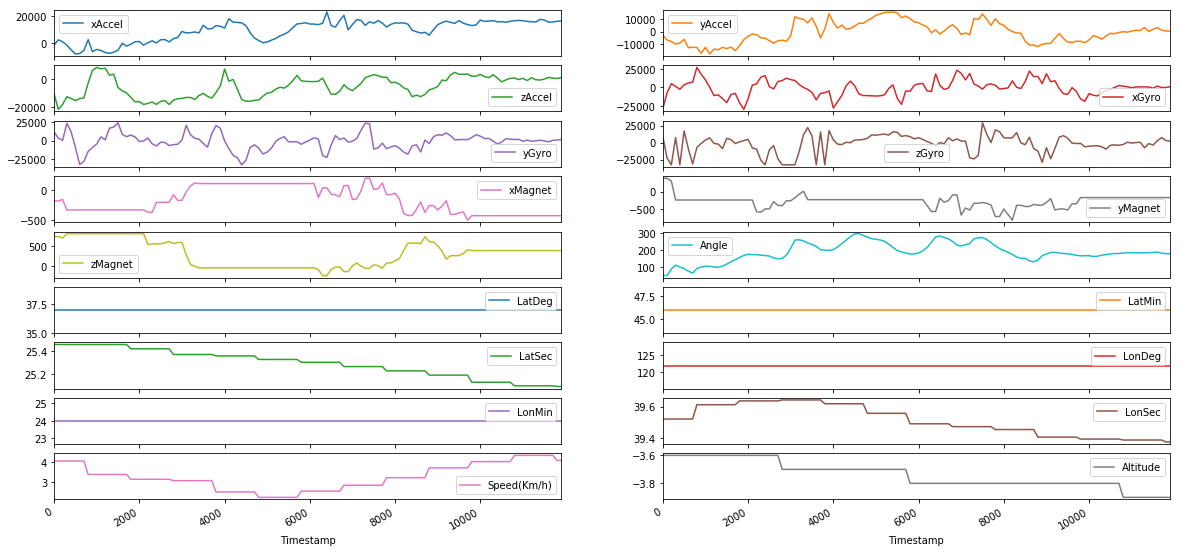

In [10]:
multiplot_file(non_jumping_files[1]).head()

It looks like the ranges of values for jumping and non-jumping aren't particularly different which may mean that using things like min and max values won't work well. Let's load all of the timeseries data and look at it for jumpers and non-jumpers.

It also looks like that while the ranges are fairly close they're smoother for non-jumpers. Perhaps computing an FFT and looking at the magnitude of the high frequencies would be a useful feature. I'm not entirely sure how to do that in Python quickly so will first see if my assumption and ranges is correct before I start reading a bunch of scipy docs.

In [18]:
columns_of_interest = jf1.describe().drop('Timestamp', axis=1).columns
columns_of_interest

Index(['xAccel', 'yAccel', 'zAccel', 'xGyro', 'yGyro', 'zGyro', 'xMagnet',
       'yMagnet', 'zMagnet', 'Angle'],
      dtype='object')

In [20]:
rows_of_interest = ('mean', 'std', 'min', '50%', 'max')
train1 = train_raw.copy()

In [30]:
def compute_summaries(fname_base):
    """Give the base filename, minus the .CSV part, compute the mean, min, max, etc. for each column of
    interest and return that as a labelled Pandas Series so tha we can later use apply to merge in these
    computed columns."""
    df = load_sensor_file(fname_base + '.CSV')
    summary = df.describe()
    res = {}
    for col in columns_of_interest:
        for row in rows_of_interest:
            res['%s_%s' % (col, row)] = summary.loc[row, col]
    return pd.Series(res)

compute_summaries(train1.Filename[0])
    

Angle_50%         191.497500
Angle_max         198.248000
Angle_mean        191.220269
Angle_min         177.501000
Angle_std           3.004370
xAccel_50%      16222.000000
xAccel_max      32744.000000
xAccel_mean     15269.500000
xAccel_min     -32768.000000
xAccel_std       7759.570165
xGyro_50%         -48.000000
xGyro_max       14180.000000
xGyro_mean        249.961538
xGyro_min       -9352.000000
xGyro_std        3620.687195
xMagnet_50%      -397.500000
xMagnet_max      -250.000000
xMagnet_mean     -381.076923
xMagnet_min      -450.000000
xMagnet_std        47.828312
yAccel_50%       -278.000000
yAccel_max       9096.000000
yAccel_mean      -316.923077
yAccel_min     -12592.000000
yAccel_std       2356.592256
yGyro_50%        -243.000000
yGyro_max        6796.000000
yGyro_mean       -212.634615
yGyro_min       -8742.000000
yGyro_std        2306.806632
yMagnet_50%      -388.000000
yMagnet_max      -312.000000
yMagnet_mean     -382.951923
yMagnet_min      -474.000000
yMagnet_std   

In [31]:
train1 = train1.merge(train1.Filename.apply(compute_summaries), left_index=True, right_index=True)
train1.head()

Filename  Classification Description  Angle_50%  Angle_max  Angle_mean  \
0  REVL0003               1     Jumping   191.4975    198.248  191.220269   
1  REVL0004               1     Jumping   191.0055    201.736  191.231368   
2  REVL0005               1     Jumping   190.5275    198.182  190.532519   
3  REVL0006               1     Jumping   192.6260    197.606  192.727564   
4  REVL0007               1     Jumping   191.2940    199.319  191.373577   

   Angle_min  Angle_std  xAccel_50%  xAccel_max     ...       zGyro_50%  \
0    177.501   3.004370     16222.0     32744.0     ...          -317.0   
1    185.477   2.547216     16046.0     30504.0     ...           117.0   
2    173.936   4.221705     16078.0     31716.0     ...          -209.0   
3    187.141   2.106292     16270.0     25416.0     ...           -62.0   
4    184.493   2.492943     16496.0     28976.0     ...           -20.0   

   zGyro_max  zGyro_mean  zGyro_min    zGyro_std  zMagnet_50%  zMagnet_max  \
0     7088.0 -307.461538    -9976.0  2250.167825        106.0        173.0   
1    11074.0   83.396226    -7878.0  2152.809764        333.0        412.0   
2     5828.0 -292.442308   -12938.0  2268.889501         77.0        145.0   
3     8484.0  -39.127660   -10596.0  2644.361932        321.5        401.0   
4    20990.0  352.226804   -10918.0  3266.384799         90.0        176.0   

   zMagnet_mean  zMagnet_min  zMagnet_std  
0    103.307692         12.0    29.652052  
1    330.990566        231.0    40.078137  
2     71.298077        -31.0    37.362013  
3    327.978723        223.0    41.775380  
4     90.608247        -16.0    31.160725  

[5 rows x 53 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93f944a518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f93f87e8630>]], dtype=object)

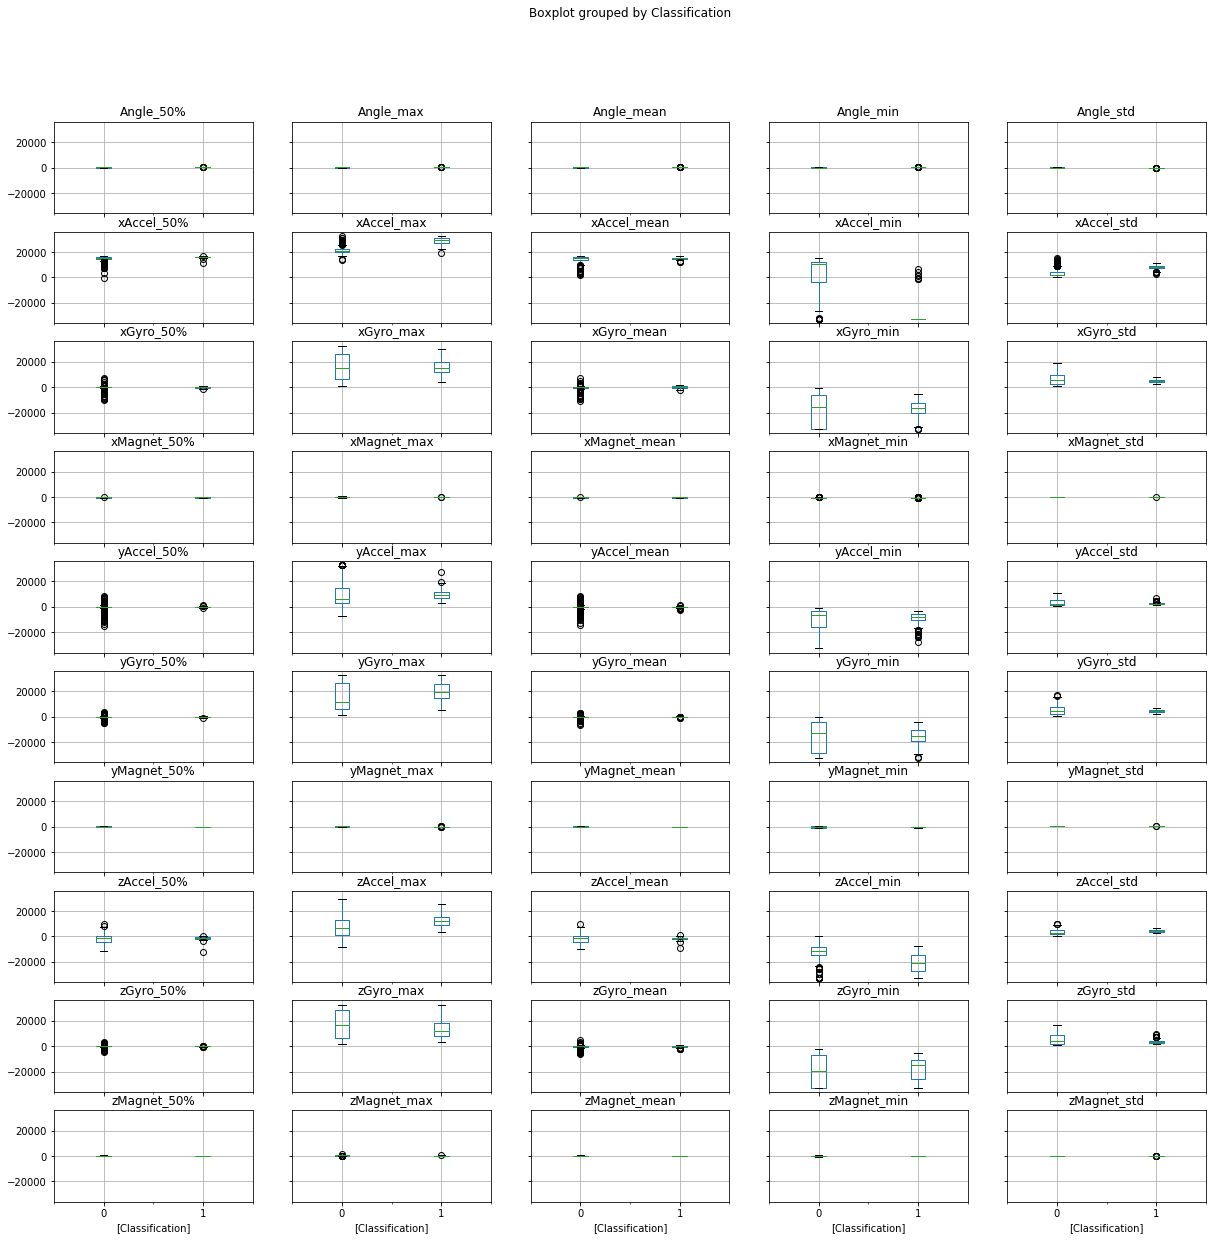

In [40]:
train1.boxplot(by='Classification', figsize=(20, 20), layout=(-1, 5))

Interestingly there seems to be **more** variation in a number of the metrics for the non-jumping cases. For example, yAcces_max is more varied for non-jumpers that for jumpers (and as a result yAcced_std is smaller for jumpers).

Unfortunately, it's a bit hard to look at some of these as they share a y-axis range and that's not helpful so I'll redo it with individual plots.

In [53]:
to_plot = list(train1.drop(['Filename', 'Classification', 'Description'], axis=1).columns)
to_plot

['Angle_50%',
 'Angle_max',
 'Angle_mean',
 'Angle_min',
 'Angle_std',
 'xAccel_50%',
 'xAccel_max',
 'xAccel_mean',
 'xAccel_min',
 'xAccel_std',
 'xGyro_50%',
 'xGyro_max',
 'xGyro_mean',
 'xGyro_min',
 'xGyro_std',
 'xMagnet_50%',
 'xMagnet_max',
 'xMagnet_mean',
 'xMagnet_min',
 'xMagnet_std',
 'yAccel_50%',
 'yAccel_max',
 'yAccel_mean',
 'yAccel_min',
 'yAccel_std',
 'yGyro_50%',
 'yGyro_max',
 'yGyro_mean',
 'yGyro_min',
 'yGyro_std',
 'yMagnet_50%',
 'yMagnet_max',
 'yMagnet_mean',
 'yMagnet_min',
 'yMagnet_std',
 'zAccel_50%',
 'zAccel_max',
 'zAccel_mean',
 'zAccel_min',
 'zAccel_std',
 'zGyro_50%',
 'zGyro_max',
 'zGyro_mean',
 'zGyro_min',
 'zGyro_std',
 'zMagnet_50%',
 'zMagnet_max',
 'zMagnet_mean',
 'zMagnet_min',
 'zMagnet_std']

In [46]:
plot_grid = (len(to_plot)/5, 5)
plot_grid

(10.0, 5)

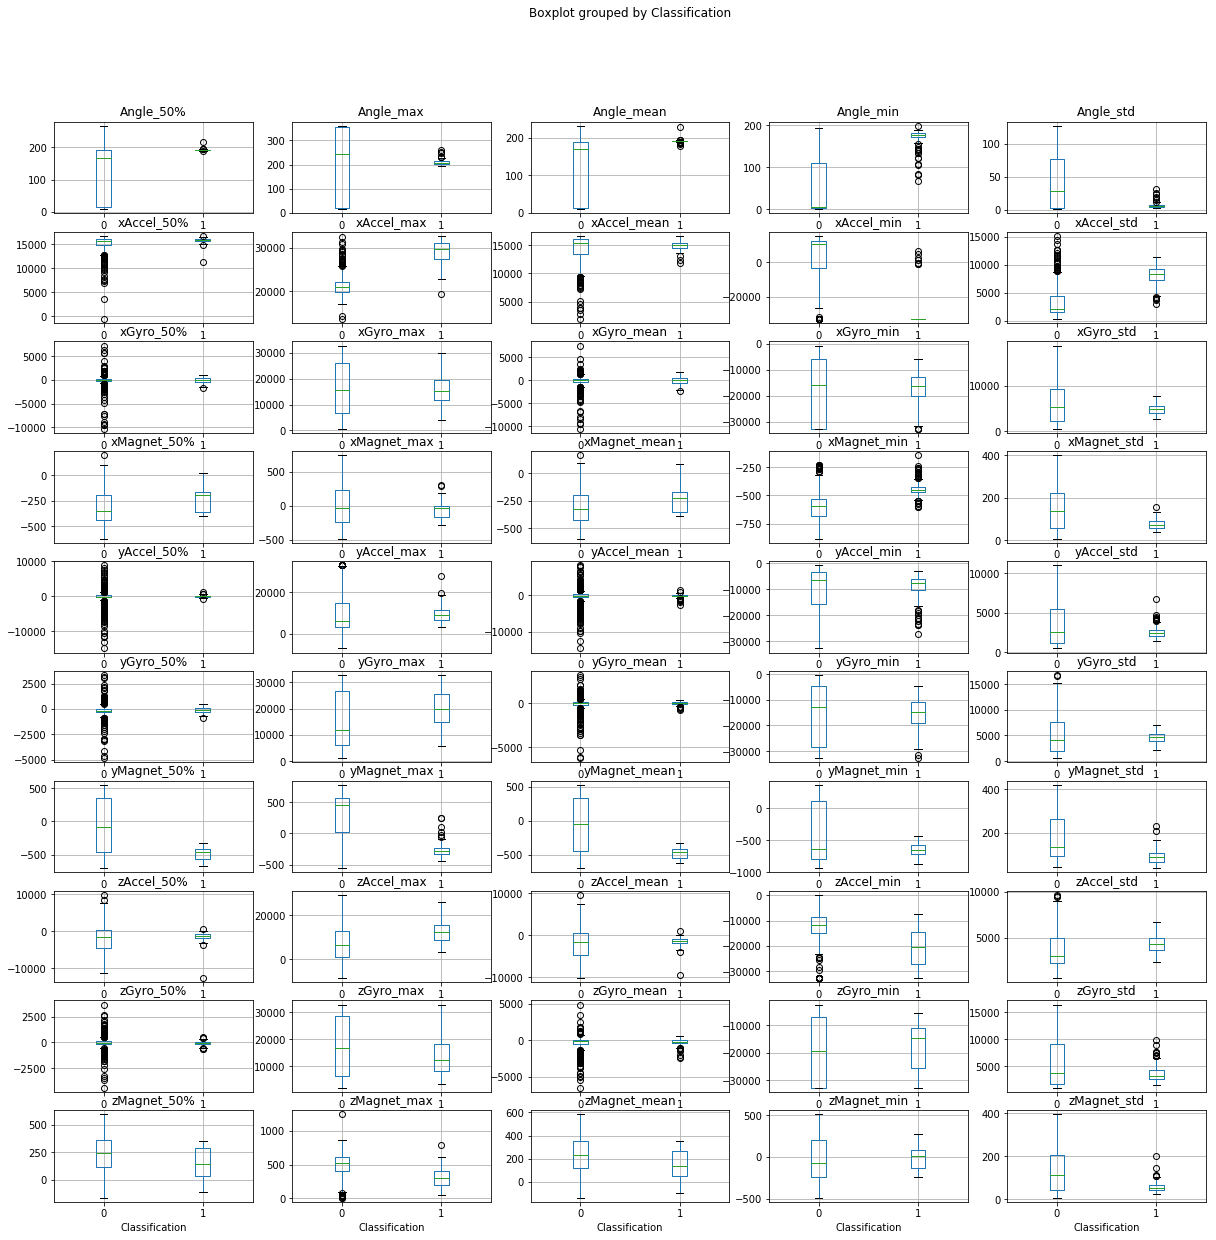

In [55]:
fig, axes = plt.subplots(nrows=int(plot_grid[0]), ncols=plot_grid[1], sharey=False, figsize=(20, 20))
for plot_num, col in enumerate(to_plot):
    prow = int(plot_num / 5)
    pcol = int(plot_num % 5)
    train1.boxplot(by='Classification', column=col, ax=axes[prow, pcol])

This looks promising. There are several features which appear to be different for jumpers and non-jumpers. For example:

* non-jumpers have a much wider range of angles
* maximum xAccel is generally higher for jumpers
* minimum xAccel is much lower for jumpers
* etc.

Lets try building a very simple logistic regression model for this. We can try feature selection, etc. later.

In [57]:
train1.shape

(563, 53)

Ony 563 training examples which isn't a lot so let's use 10-fold cross validation instead of splitting into train and test data sets.

In [64]:
from sklearn.linear_model import LogisticRegression
# Start with defaults (no regularization)
lr = LogisticRegression()

In [66]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(shuffle = True, n_splits=10)
accuracies = cross_val_score(lr, train1[to_plot].values, train1.Classification, cv=kf)
accuracies

array([ 1.        ,  0.98245614,  0.98245614,  0.98214286,  1.        ,
        1.        ,  0.98214286,  0.92857143,  0.92857143,  0.96428571])

In [67]:
import scipy
scipy.stats.describe(accuracies)

DescribeResult(nobs=10, minmax=(0.9285714285714286, 1.0), mean=0.97506265664160396, variance=0.00072380111375626379, skewness=-0.9273656130350499, kurtosis=-0.5189642229507498)

Average 97.5% accuracy for this very simple classifier! Not bad. It seems unlikely that we can do a whole lot better with a more complex model!

Before we just accept this, I'm curious to see some of the model info like the coefficients, etc.

In [96]:
# Train on everything
lr.fit(train1[to_plot].values, train1.Classification)
col_and_coef = [(np.abs(coef), coef, col) for coef, col in  zip(lr.coef_[0, :], to_plot)]
col_and_coef.sort()
col_and_coef

[(0.00011989325260311262, 0.00011989325260311262, 'yGyro_max'),
 (0.00012460608923938526, 0.00012460608923938526, 'Angle_max'),
 (0.0001567578838223312, -0.0001567578838223312, 'Angle_std'),
 (0.00019010356756912937, 0.00019010356756912937, 'xGyro_max'),
 (0.0001905672316416104, -0.0001905672316416104, 'zGyro_mean'),
 (0.00025470271645642429, 0.00025470271645642429, 'xMagnet_mean'),
 (0.00030977789658895115, -0.00030977789658895115, 'zMagnet_50%'),
 (0.00036245668902543565, 0.00036245668902543565, 'xMagnet_50%'),
 (0.00038860649600431547, 0.00038860649600431547, 'yGyro_min'),
 (0.00041952155955616151, 0.00041952155955616151, 'zMagnet_min'),
 (0.00051243791417168792, 0.00051243791417168792, 'yGyro_mean'),
 (0.00055331661648840339, -0.00055331661648840339, 'xMagnet_std'),
 (0.00055587423419662654, 0.00055587423419662654, 'Angle_50%'),
 (0.00055802016295536459, 0.00055802016295536459, 'Angle_mean'),
 (0.00055957421961117817, -0.00055957421961117817, 'zAccel_min'),
 (0.00057478815179723625

Which looks about right - the most important features generally also had boxplots that looked promising. Other features like magnetare less important and, again, that matches our boxplot.

As noted above, it appears that we're doing quite well overall though our accuracy is as low as 92% on one of the folds. That likely won't be an issue since a model trained on all the data should be more robust, but just for kicks, let's try improving things. We will use l1 regularization to get an approimation to feature selection which may help with generalization.

In [86]:
from sklearn.linear_model import LogisticRegressionCV
lr_regularized = LogisticRegressionCV(cv = kf, penalty='l1', solver='liblinear')
lr_regularized.fit(train1[to_plot].values, train1.Classification)

LogisticRegressionCV(Cs=10, class_weight=None,
           cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l1',
           random_state=None, refit=True, scoring=None, solver='liblinear',
           tol=0.0001, verbose=0)

In [92]:
lr_regularized.scores_[1].mean(axis=0)

array([ 0.98217419,  0.98756266,  0.97869674,  0.98048246,  0.98756266,
        0.99110276,  0.99110276,  0.99110276,  0.99110276,  0.99110276])

In [93]:
lr_regularized.Cs_

array([  1.00000000e-04,   7.74263683e-04,   5.99484250e-03,
         4.64158883e-02,   3.59381366e-01,   2.78255940e+00,
         2.15443469e+01,   1.66810054e+02,   1.29154967e+03,
         1.00000000e+04])

So larger C values help. However, in scikit-learn the penalties are **inverse** of the normal penlalty so the best results appear to start with the 6th C value which is a penalty weight of 1/2.7825594 ~ 0.36. Let's train a model with that parameter and see if it actually made things significantly sparser.

In [97]:
lr2 = LogisticRegression(penalty='l1', solver='liblinear')
lr2.fit(train1[to_plot].values, train1.Classification)
col_and_coef = [(np.abs(coef), coef, col) for coef, col in  zip(lr2.coef_[0, :], to_plot)]
col_and_coef.sort()
col_and_coef

[(0.0, 0.0, 'Angle_max'),
 (0.0, 0.0, 'Angle_mean'),
 (0.0, 0.0, 'Angle_std'),
 (0.0, 0.0, 'xMagnet_50%'),
 (0.0, 0.0, 'xMagnet_mean'),
 (0.0, 0.0, 'xMagnet_std'),
 (0.0, 0.0, 'yMagnet_50%'),
 (0.0, 0.0, 'yMagnet_mean'),
 (0.0, 0.0, 'zMagnet_50%'),
 (0.0, 0.0, 'zMagnet_std'),
 (1.5599337686826029e-05, 1.5599337686826029e-05, 'yAccel_min'),
 (6.6508384545436056e-05, -6.6508384545436056e-05, 'xGyro_max'),
 (7.2534279933553301e-05, 7.2534279933553301e-05, 'yAccel_max'),
 (0.00010970273386174824, -0.00010970273386174824, 'yAccel_mean'),
 (0.00012933168554942474, -0.00012933168554942474, 'yGyro_max'),
 (0.0001591846160292728, 0.0001591846160292728, 'xAccel_max'),
 (0.00018938800618569965, 0.00018938800618569965, 'xGyro_mean'),
 (0.00019085906612722141, -0.00019085906612722141, 'zGyro_max'),
 (0.00019653894823511256, 0.00019653894823511256, 'xGyro_min'),
 (0.00020428570362286073, -0.00020428570362286073, 'yGyro_min'),
 (0.0002194045523490334, 0.0002194045523490334, 'zAccel_mean'),
 (0.000244

So that removed 10 features from our model and made us more accurate overall.

In [99]:
# Check the accuracy of this new model
accuracies = cross_val_score(lr2, train1[to_plot].values, train1.Classification, cv=kf)
accuracies

array([ 1.        ,  0.96491228,  0.96491228,  1.        ,  1.        ,
        0.98214286,  0.98214286,  1.        ,  0.98214286,  1.        ])

In [100]:
scipy.stats.describe(accuracies)

DescribeResult(nobs=10, minmax=(0.96491228070175439, 1.0), mean=0.98762531328320802, variance=0.00020973333675318917, skewness=-0.5573432962581367, kurtosis=-1.1694620459590885)

That looks great! I think we can use this as our final model. All that's left:

1. Re-train on the full data set
2. Import and set up the test data
3. Score the test data and save it

In [102]:
lr_final = LogisticRegression(penalty='l1', solver='liblinear')
lr_final.fit(train1[to_plot].values, train1.Classification)
# We score even though there was no hold out data just as a double check. We expect to be **very** accurate
lr_final.score(train1[to_plot].values, train1.Classification)

1.0

In [103]:
# Load and transform the test data
test_raw = pd.read_csv('./RevlMLChallengeData/TestDataClassification.csv')
test_raw.head()

Filename  Classification  Description
0  REVL0009             NaN          NaN
1  REVL0037             NaN          NaN
2  REVL0055             NaN          NaN
3  REVL0072             NaN          NaN
4  REVL0092             NaN          NaN

In [105]:
test = test_raw.merge(test_raw.Filename.apply(compute_summaries), left_index=True, right_index=True)
test.head()

Filename  Classification  Description  Angle_50%  Angle_max  Angle_mean  \
0  REVL0009             NaN          NaN   191.1950    201.544  191.117667   
1  REVL0037             NaN          NaN   191.1510    199.764  191.224973   
2  REVL0055             NaN          NaN   189.6240    220.221  190.219722   
3  REVL0072             NaN          NaN   192.9775    227.609  193.732185   
4  REVL0092             NaN          NaN   192.5900    202.253  192.123422   

   Angle_min  Angle_std  xAccel_50%  xAccel_max     ...       zGyro_50%  \
0    184.356   2.472817     16176.0     29380.0     ...          -248.0   
1    182.549   3.905407     15758.0     27344.0     ...             3.0   
2    137.472   9.243501     16308.0     27508.0     ...           304.0   
3    176.221   7.129030     16082.0     29148.0     ...           149.0   
4    178.956   5.071828     15976.0     26308.0     ...           123.0   

   zGyro_max  zGyro_mean  zGyro_min    zGyro_std  zMagnet_50%  zMagnet_max  \
0    13654.0 -180.666667   -10780.0  2636.980976         97.0        141.0   
1     6780.0 -153.272727   -10368.0  2290.916370         76.0        191.0   
2    27200.0  511.165217   -20320.0  4480.964840         63.0        190.0   
3     8644.0 -138.833333   -17454.0  3277.981931        314.5        379.0   
4    17120.0  149.810345    -8818.0  2559.114561        294.0        388.0   

   zMagnet_mean  zMagnet_min  zMagnet_std  
0     93.628571        -10.0    32.402593  
1     75.654545        -51.0    46.264583  
2     53.078261       -223.0    77.091669  
3    300.990741         99.0    57.790711  
4    294.275862        192.0    41.278394  

[5 rows x 53 columns]

In [108]:
test.shape

(40, 53)

In [111]:
posteriors = lr_final.predict_proba(test[to_plot].values)

In [118]:
prediction = posteriors.argmax(axis=1)


In [119]:
to_submit = test_raw.copy()
to_submit['predicted'] = prediction
# Posterior probabiliy that this was a jump
to_submit['postior_jump'] = posteriors[:, 1]
# Posterior probabiliy that this was **not** a jump
to_submit['postior_not_jump'] = posteriors[:, 0]
to_submit

Filename  Classification  Description  predicted  postior_jump  \
0   REVL0009             NaN          NaN          1  1.000000e+00   
1   REVL0037             NaN          NaN          1  1.000000e+00   
2   REVL0055             NaN          NaN          1  1.000000e+00   
3   REVL0072             NaN          NaN          1  1.000000e+00   
4   REVL0092             NaN          NaN          1  1.000000e+00   
5   REVL0109             NaN          NaN          1  1.000000e+00   
6   REVL0130             NaN          NaN          1  1.000000e+00   
7   REVL0148             NaN          NaN          1  9.999990e-01   
8   REVL0162             NaN          NaN          1  1.000000e+00   
9   REVL0182             NaN          NaN          1  1.000000e+00   
10  REVL0201             NaN          NaN          1  1.000000e+00   
11  REVL0136             NaN          NaN          1  1.000000e+00   
12  REVL0115             NaN          NaN          1  1.000000e+00   
13  REVL0101             NaN          NaN          1  1.000000e+00   
14  REVL0081             NaN          NaN          1  9.999341e-01   
15  REVL0063             NaN          NaN          1  1.000000e+00   
16  REVL0046             NaN          NaN          1  1.000000e+00   
17  REVL0025             NaN          NaN          1  1.000000e+00   
18  REVL0015             NaN          NaN          1  9.994546e-01   
19  REVL0031             NaN          NaN          1  1.000000e+00   
20  REVL0463             NaN          NaN          1  8.411435e-01   
21  REVL0480             NaN          NaN          0  5.980748e-26   
22  REVL0493             NaN          NaN          0  1.465532e-18   
23  REVL0509             NaN          NaN          0  2.405293e-31   
24  REVL0520             NaN          NaN          0  2.295118e-23   
25  REVL0530             NaN          NaN          0  1.296505e-25   
26  REVL0541             NaN          NaN          0  5.221792e-09   
27  REVL0552             NaN          NaN          0  1.575648e-14   
28  REVL0569             NaN          NaN          0  5.253323e-16   
29  REVL0638             NaN          NaN          0  6.897574e-09   
30  REVL0264             NaN          NaN          0  1.460745e-08   
31  REVL0285             NaN          NaN          0  6.056181e-07   
32  REVL0303             NaN          NaN          0  1.874584e-07   
33  REVL0319             NaN          NaN          0  2.670401e-08   
34  REVL0337             NaN          NaN          0  2.009466e-14   
35  REVL0364             NaN          NaN          0  1.192858e-08   
36  REVL0381             NaN          NaN          0  5.005734e-07   
37  REVL0408             NaN          NaN          0  3.507905e-04   
38  REVL0422             NaN          NaN          0  1.502877e-05   
39  REVL0435             NaN          NaN          0  4.913296e-09   

    postior_not_jump  
0       0.000000e+00  
1       0.000000e+00  
2       8.082078e-09  
3       0.000000e+00  
4       0.000000e+00  
5       0.000000e+00  
6       9.103829e-15  
7       9.810908e-07  
8       1.465494e-14  
9       0.000000e+00  
10      1.554312e-15  
11      2.131628e-14  
12      9.177770e-12  
13      0.000000e+00  
14      6.592045e-05  
15      0.000000e+00  
16      0.000000e+00  
17      0.000000e+00  
18      5.453533e-04  
19      3.774758e-15  
20      1.588565e-01  
21      1.000000e+00  
22      1.000000e+00  
23      1.000000e+00  
24      1.000000e+00  
25      1.000000e+00  
26      1.000000e+00  
27      1.000000e+00  
28      1.000000e+00  
29      1.000000e+00  
30      1.000000e+00  
31      9.999994e-01  
32      9.999998e-01  
33      1.000000e+00  
34      1.000000e+00  
35      1.000000e+00  
36      9.999995e-01  
37      9.996492e-01  
38      9.999850e-01  
39      1.000000e+00

In [121]:
to_submit.to_csv('./scored.csv', index=False)